In [1]:
from astropy.io import fits

hat = fits.open('hat-p-7_b/hat-p-7_b.fits')
hat.info()

Filename: hat-p-7_b/hat-p-7_b.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  TCE_3         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  4  TCE_4         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  5  TCE_5         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  6  TCE_6         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  7  TCE_7         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  8  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [2]:
from astropy.table import Table

PRIMARY = hat['PRIMARY']

TCE_1 = hat['TCE_1']
table_tce1 = Table.read(TCE_1) #¿se puede hacer un array de BinTablesHDU?


TCE_2 = hat['TCE_2']
table_tce2 = Table.read(TCE_2) #¿se puede hacer un array de BinTablesHDU?


TCE_3 = hat['TCE_3']
table_tce3 = Table.read(TCE_3) #¿se puede hacer un array de BinTablesHDU?


TCE_4 = hat['TCE_4']
table_tce4 = Table.read(TCE_4) #¿se puede hacer un array de BinTablesHDU?


TCE_5 = hat['TCE_5']
table_tce5 = Table.read(TCE_5) #¿se puede hacer un array de BinTablesHDU?


TCE_6 = hat['TCE_6']
table_tce6 = Table.read(TCE_6) #¿se puede hacer un array de BinTablesHDU?


TCE_7 = hat['TCE_7']
table_tce7 = Table.read(TCE_7)

table_tce1

TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
BJD - 2454833,d,,days,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless
float64,float32,int32,float32,float32,float32,float32,float32,float32,float32
1.3151205e+02,-1.059829e-03,1105,1.3335272e+00,-3.9541512e-05,2.5503115e-05,-3.4372607e-01,-3.9541512e-05,0.0000000e+00,1.0576324e-01
1.3153249e+02,-1.060562e-03,1106,1.3539616e+00,-2.2603195e-05,2.5496436e-05,2.9184762e-02,-2.2603195e-05,0.0000000e+00,2.0860007e-01
1.3155292e+02,-1.061294e-03,1107,1.3743960e+00,-3.5658915e-05,2.5480678e-05,-1.1320674e-01,-3.5658915e-05,0.0000000e+00,3.0092743e-01
1.3157336e+02,-1.062026e-03,1108,1.3948301e+00,-3.3626442e-05,2.5509618e-05,-4.3413952e-02,-3.3626442e-05,0.0000000e+00,3.7470224e-01
1.3159379e+02,-1.062758e-03,1109,1.4152645e+00,7.2438757e-05,2.5514733e-05,1.6507578e+00,7.2438757e-05,0.0000000e+00,4.2141774e-01
1.3161423e+02,-1.063491e-03,1110,1.4356989e+00,-1.9167643e-05,2.5512811e-05,1.9305673e-01,-1.9167643e-05,0.0000000e+00,4.3312293e-01
1.3163466e+02,-1.064223e-03,1111,1.4561331e+00,-7.2684234e-05,2.5516729e-05,-7.3616058e-01,-7.2684234e-05,0.0000000e+00,4.0229556e-01
1.3165509e+02,-1.064955e-03,1112,1.4765675e+00,-2.8484281e-05,2.5502908e-05,-1.6856681e-01,-2.8484281e-05,0.0000000e+00,3.2288116e-01


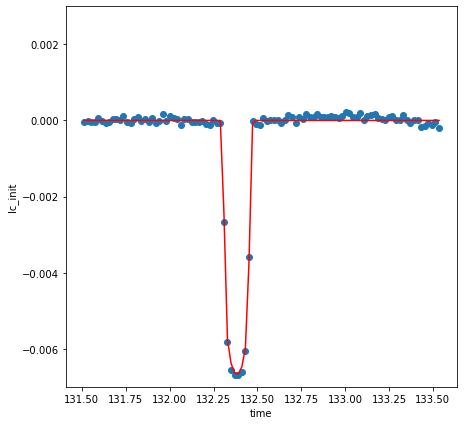

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


tce1_time = table_tce1['TIME'].data
# tce1_timecorr = table_tce1['TIMECORR'].data
# tce1_cadenceno = table_tce1['CADENCENO'].data
# tce1_phase = table_tce1['PHASE'].data
tce1_lc_init = table_tce1['LC_INIT'].data
tce1_lc_init_err = table_tce1['LC_INIT_ERR'].data
tce1_lc_white = table_tce1['LC_WHITE'].data
tce1_lc_detrend = table_tce1['LC_DETREND'].data
tce1_model_init = table_tce1['MODEL_INIT'].data
tce1_model_white = table_tce1['MODEL_WHITE'].data

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(tce1_time[0:100], tce1_lc_init[0:100])
#IMPORTANT NOTE: for the range [0:200] there are Nan values, which mess both with curve fitting or 
ax.plot(tce1_time[0:100], tce1_model_init[0:100], '-r')
ax.set_ylim(-0.007,0.003)
ax.set_xlabel('time')
ax.set_ylabel('lc_init')

# fig, ax = plt.subplots(1,3, figsize=(16,16))

# ax[0].plot(tce1_time[0:200], tce1_lc_init[0:200], '-k')
# ax[0].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
# ax[0].set_ylim(-0.007,0.003)
# ax[0].set_xlabel('time')
# ax[0].set_ylabel('lc_init')

# ax[1].plot(tce1_time[0:200], tce1_lc_white[0:200])
# ax[1].plot(tce1_time[0:200], tce1_model_white[0:200], '-r')
# ax[1].set_ylim(-90, 55)
# ax[1].set_xlabel('time')
# ax[1].set_ylabel('lc_white')

# ax[2].plot(tce1_time[0:200], tce1_lc_detrend[0:200], '-g')
# ax[2].plot(tce1_time[0:200], tce1_model_init[0:200], '-r')
# ax[2].set_ylim(-0.007,0.003)
# ax[2].set_xlabel('time')
# ax[2].set_ylabel('lc_detrend')


plt.show()


In [15]:
import numpy as np

t = tce1_time
r = np.arange(0., 1.+0.0001, 0.0001)

def lightcurve_fit(t, p:float, a:float, b:float, gamma1:float, gamma2:float, T:float, delta:float):
    
    h = 0.0001 #integral and derivate step
    r = np.arange(0., 1.+h, h)
    
    d = np.zeros(r.shape)
    
    x = a*np.cos(omega*t+delta)
    
    z_range = np.sqrt(x**2 + b**2)
    
    #INTEGRAL 1
    
    integral_1 = 0
    
    #Function F^e*r**2
    
    P = p/r
    z0 = z_range/r
       
        # Reflects the information w.r.t. the y axis  
    if z0>0:
        z = z0
        
    if z0<0:
        z = -z0

    if z>1+p:
        F_e = 1.
        return F_e
    elif (abs(1-P)<z and z<=1+P):
        k0 = np.arccos((P**2 + z**2 -1)/(2*P*z))
        k1 = np.arccos((1-P**2 + z**2)/(2*z))
        L0 = k0***2
        L2 = np.sqrt((4*z**2- (1+z**2-P**2)**2)/4) 
        F_e =  (1-(L0 + k1 - L2)/np.pi)*r**2
        return F_e
    elif (z<=1-P):
        F_e =  (1-P**2)*r**2   
        return F_e
    elif z<= P-1: 
        F_e = 0.
        return F_e
    
    #Limb darkening function
    
    mu = np.sqrt(1-r**2) 
    I_function = 1. - gamma1*(1-mu) - gamma2*(1-mu)**2
    
        #derivate
    derivate[0] = F_e[0]
    
    for i in range (r.shape):    
        derivate[i+1] = (F_e[i+1]-F_e[i])/h #Euler algorithm
        Integral_1 = Integral_1 + h*I_function[i]*derivate[i]
        
    #INTEGRAL 2
    
    Integral_2 = 0.
    
    for i in range (r.shape):
        Integral_2 = Integral_2 + h*2*r[i]*I_function[i]
        
        
    return Integral_1/Integral_2

In [ ]:
from scipy.ndimage import minimum as min
F = tce1_lc_init[0:100]+1
F_t = min(F[0:100]) #minimum light flux value due to the transit (THEN WE WILL NEED TO FIND THE ERROR)
F_no_t = 1.0 #value of the flux with the mean centered in cero

Delta_F = (F_no_t - F_t)/F_t
Delta_F

In [14]:
r = np.arange(0.0001, 1.+0.0001, 0.0001)

p  = 5./r
p

array([5.00000000e+04, 2.50000000e+04, 1.66666667e+04, ...,
       5.00100020e+00, 5.00050005e+00, 5.00000000e+00])

---
## References


1. K. Mandel and E. Agol. *Analytic Lightcurves for Planetary Transit Searches*. [astro-ph:0210099](https://arxiv.org/pdf/astro-ph/0210099.pdf).
2. S. E. Thompson 2016, Data Validation Time Series
File: Description of the File Format and Content, KSCI-19079-001.